In [49]:
import numpy as np 
import pandas as pd 

import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [54]:
train_bureau_raw = pd.read_csv('../input/train_bureau_raw.csv')
test_bureau_raw = pd.read_csv('../input/test_bureau_raw.csv')

train_bureau_missing_removed = pd.read_csv('../input/train_bureau_missing_drop.csv')
test_bureau_missing_removed = pd.read_csv('../input/test_bureau_missing_drop.csv')

train_bureau_corrs_removed = pd.read_csv('../input/train_bureau_corrs_removed.csv')
test_bureau_corrs_removed = pd.read_csv('../input/test_bureau_corrs_removed.csv')

In [91]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Args:
        features (pd.DataFrame): dataframe of training features to use 
        for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): dataframe of testing features to use
        for making predictions with the model. 
        encoding (str, default = 'ohe'): method for encoding categorical 
        variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
        n_folds (int, default = 5): number of folds to use for cross validation
        
    Returns:
        submission (pd.DataFrame): dataframe with `SK_ID_CURR` and `TARGET` probabilities
        predicted by the model.
        feature_importances (pd.DataFrame): dataframe with the feature importances
        from the model.
        valid_metrics (pd.DataFrame): dataframe with validation metrics (ROC AUC) for 
        each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary',
                                   learning_rate = 0.1, max_depth = 10,
                                   reg_alpha = 0.2, reg_lambda = 0.2, subsample = 0.8, 
                                   n_jobs = -1, random_state = 50,
                                   class_weight = 'balanced')
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [92]:
def plot_feature_importances(df):
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

In [93]:
submission_raw, fi_raw, metrics_raw = model(train_bureau_raw, 
                                            test_bureau_raw,
                                            encoding = 'ohe')

Training Data Shape:  (307511, 349)
Testing Data Shape:  (48744, 349)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.764206	train's auc: 0.841973
Early stopping, best iteration is:
[131]	valid's auc: 0.764714	train's auc: 0.819564
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.768191	train's auc: 0.841703
Early stopping, best iteration is:
[157]	valid's auc: 0.768775	train's auc: 0.828055
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.758064	train's auc: 0.843273
Early stopping, best iteration is:
[190]	valid's auc: 0.758393	train's auc: 0.840376
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.766006	train's auc: 0.841122
Early stopping, best iteration is:
[120]	valid's auc: 0.767229	train's auc: 0.815108
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.767499	train's auc: 0.841186
Early stopping, best iter

In [94]:
metrics_raw

,fold,train,valid
0,0,0.819564,0.764714
1,1,0.828055,0.768775
2,2,0.840376,0.758393
3,3,0.815108,0.767229
4,4,0.828381,0.768109
5,overall,0.826297,0.765337


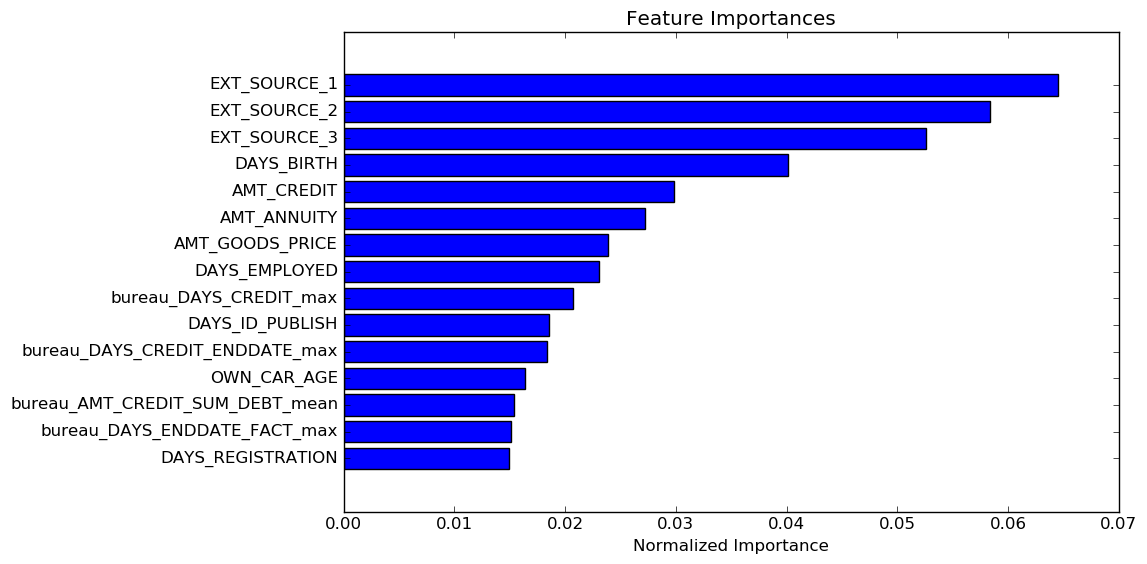

In [53]:
plot_feature_importances(fi_raw)

In [55]:
submission_missing, fi_missing, metrics_missing = model(train_bureau_missing_removed, 
                                                        test_bureau_missing_removed,
                                                        encoding = 'ohe')

Training Data Shape:  (307511, 313)
Testing Data Shape:  (48744, 313)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.766026	train's auc: 0.842375
Early stopping, best iteration is:
[213]	valid's auc: 0.766328	train's auc: 0.847252
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.764815	train's auc: 0.842507
Early stopping, best iteration is:
[198]	valid's auc: 0.764849	train's auc: 0.841725
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.757422	train's auc: 0.84224
Early stopping, best iteration is:
[153]	valid's auc: 0.757783	train's auc: 0.82544
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.765297	train's auc: 0.841336
Early stopping, best iteration is:
[268]	valid's auc: 0.765459	train's auc: 0.863082
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.766179	train's auc: 0.841787
Early stopping, best iterat

In [56]:
metrics_missing

,fold,metric
0,0,"{'valid': {'auc': 0.7663278761671382}, 'train'..."
1,1,"{'valid': {'auc': 0.7648492533467205}, 'train'..."
2,2,"{'valid': {'auc': 0.7577832797936479}, 'train'..."
3,3,"{'valid': {'auc': 0.7654586390124335}, 'train'..."
4,4,"{'valid': {'auc': 0.7666390189880953}, 'train'..."
5,overall,0.76421


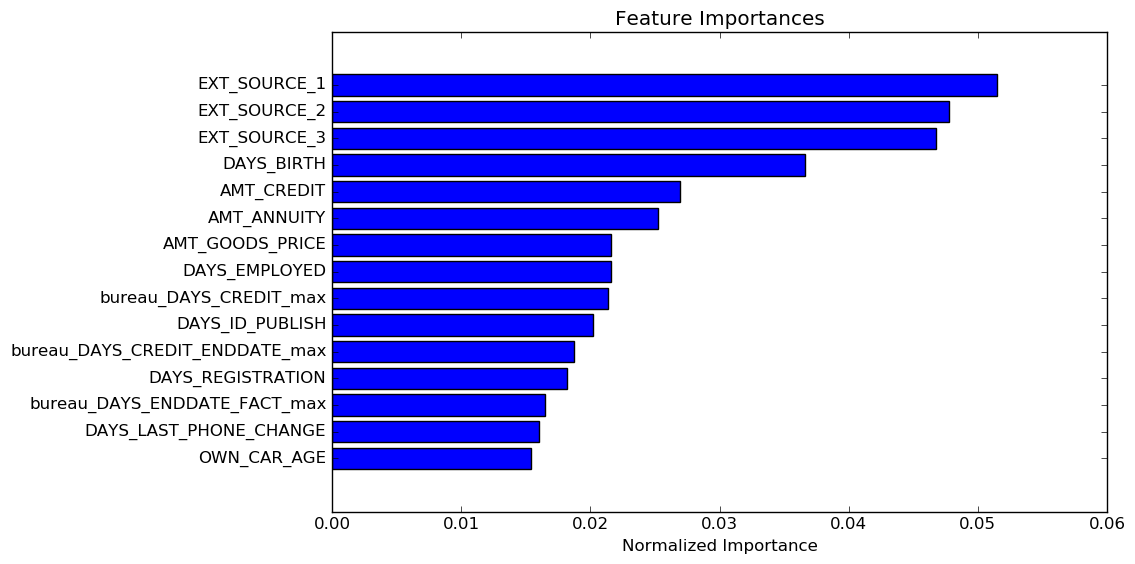

In [57]:
plot_feature_importances(fi_missing)

In [60]:
submission_corrs, feature_importances_corrs, metrics_corrs = model(train_bureau_corrs_removed, 
                                                                   test_bureau_corrs_removed,
                                                                   encoding = 'ohe')

Training Data Shape:  (307511, 284)
Testing Data Shape:  (48744, 284)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.762798	train's auc: 0.837546
Early stopping, best iteration is:
[265]	valid's auc: 0.763391	train's auc: 0.857333
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.764264	train's auc: 0.83791
Early stopping, best iteration is:
[183]	valid's auc: 0.764678	train's auc: 0.831804
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.755671	train's auc: 0.838426
Early stopping, best iteration is:
[149]	valid's auc: 0.756589	train's auc: 0.820496
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.763288	train's auc: 0.837542
Early stopping, best iteration is:
[123]	valid's auc: 0.763818	train's auc: 0.809458
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.764228	train's auc: 0.837951
Early stopping, best itera

In [61]:
metrics_corrs

,fold,metric
0,0,"{'valid': {'auc': 0.763391486992901}, 'train':..."
1,1,"{'valid': {'auc': 0.764678071793143}, 'train':..."
2,2,"{'valid': {'auc': 0.7565894885524743}, 'train'..."
3,3,"{'valid': {'auc': 0.7638178716461016}, 'train'..."
4,4,"{'valid': {'auc': 0.7645151433566778}, 'train'..."
5,overall,0.762567


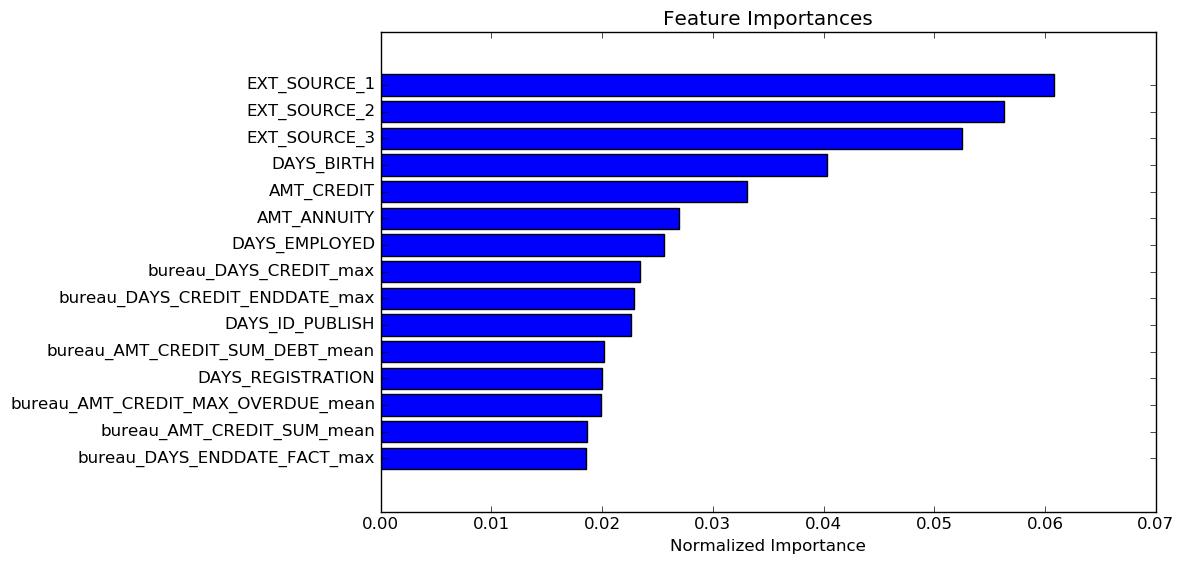

In [62]:
plot_feature_importances(feature_importances_corrs)

In [63]:
submission_raw.to_csv('submission_bureau_raw.csv', index = False)

In [65]:
submission_raw_le, fi_raw_le, metrics_raw_le = model(train_bureau_raw, 
                                            test_bureau_raw,
                                            encoding = 'le')

Training Data Shape:  (307511, 228)
Testing Data Shape:  (48744, 228)


D:\miniconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 2, 3, 9, 10, 11, 12, 13, 26, 30, 38, 84, 85, 87, 88]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.763048	train's auc: 0.848496
Early stopping, best iteration is:
[201]	valid's auc: 0.763187	train's auc: 0.84889


D:\miniconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 2, 3, 9, 10, 11, 12, 13, 26, 30, 38, 84, 85, 87, 88]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.765095	train's auc: 0.848046
Early stopping, best iteration is:
[148]	valid's auc: 0.765865	train's auc: 0.82837


D:\miniconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 2, 3, 9, 10, 11, 12, 13, 26, 30, 38, 84, 85, 87, 88]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.758262	train's auc: 0.848004
Early stopping, best iteration is:
[226]	valid's auc: 0.758443	train's auc: 0.856673


D:\miniconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 2, 3, 9, 10, 11, 12, 13, 26, 30, 38, 84, 85, 87, 88]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.764541	train's auc: 0.847397
Early stopping, best iteration is:
[157]	valid's auc: 0.765306	train's auc: 0.831692


D:\miniconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 2, 3, 9, 10, 11, 12, 13, 26, 30, 38, 84, 85, 87, 88]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.766516	train's auc: 0.848404
Early stopping, best iteration is:
[177]	valid's auc: 0.766653	train's auc: 0.839987


In [66]:
metrics_raw_le

,fold,train,valid
0,0,0.848890,0.763187
1,1,0.828370,0.765865
2,2,0.856673,0.758443
3,3,0.831692,0.765306
4,4,0.839987,0.766653
5,overall,0.841122,0.763814


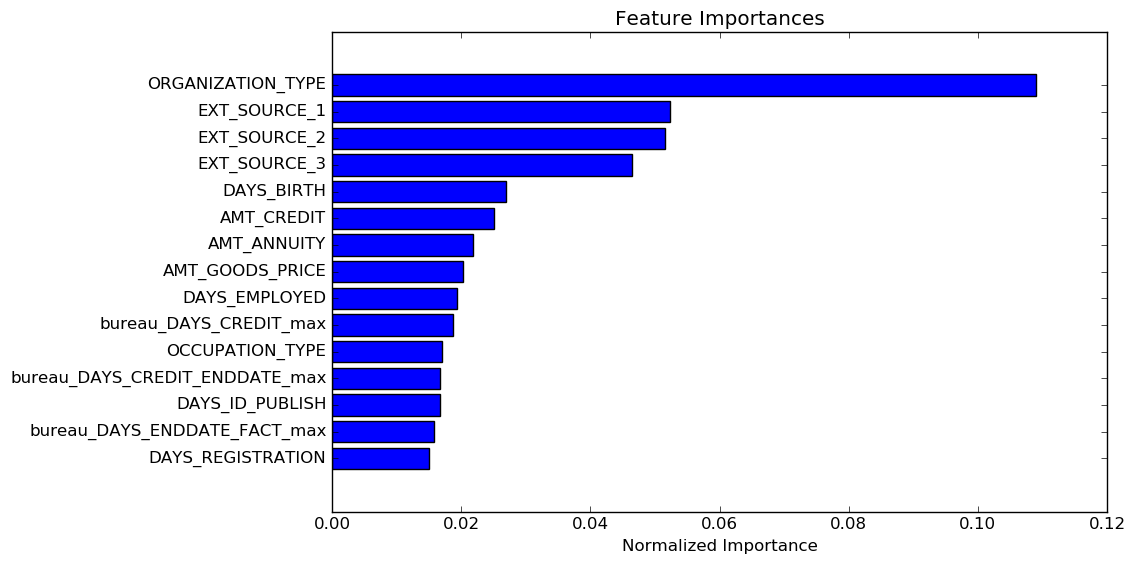

In [69]:
plot_feature_importances(fi_raw_le)

In [71]:
fi_raw = fi_raw.sort_values('importance', ascending = False).reset_index()
fi_raw.head()

,index,feature,importance
0,27,EXT_SOURCE_1,283.4
1,28,EXT_SOURCE_2,256.4
2,29,EXT_SOURCE_3,231.0
3,6,DAYS_BIRTH,176.4
4,2,AMT_CREDIT,131.0


In [72]:
fi_raw['normalized_importance'] = fi_raw['importance'] / fi_raw['importance'].sum()

In [73]:
fi_raw['cumulative_importance'] = np.cumsum(fi_raw['normalized_importance'])
fi_raw.head()

,index,feature,importance,normalized_importance,cumulative_importance
0,27,EXT_SOURCE_1,283.4,0.064526,0.064526
1,28,EXT_SOURCE_2,256.4,0.058379,0.122905
2,29,EXT_SOURCE_3,231.0,0.052596,0.175501
3,6,DAYS_BIRTH,176.4,0.040164,0.215665
4,2,AMT_CREDIT,131.0,0.029827,0.245492


In [79]:
selected = [x for x in fi_raw[fi_raw['cumulative_importance'] < 0.9]['feature']]

In [82]:
train_raw_select = pd.get_dummies(train_bureau_raw)
test_raw_select = pd.get_dummies(test_bureau_raw)

train_raw_select = train_raw_select[selected]
test_raw_select = test_raw_select[selected]

train_raw_select['SK_ID_CURR'] = train_bureau_raw['SK_ID_CURR']
train_raw_select['TARGET'] = train_bureau_raw['TARGET']
test_raw_select['SK_ID_CURR'] = test_bureau_raw['SK_ID_CURR']

print('Training Selected Shape: ', train_raw_select.shape)
print('Testing Selected Shape: ', test_raw_select.shape)

Training Selected Shape:  (307511, 109)
Testing Selected Shape:  (48744, 108)


In [83]:
submission_raw_select, fi_raw_select, metrics_raw_select = model(train_raw_select, test_raw_select, encoding = 'ohe')

Training Data Shape:  (307511, 107)
Testing Data Shape:  (48744, 107)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.763458	train's auc: 0.841351
Early stopping, best iteration is:
[159]	valid's auc: 0.764468	train's auc: 0.826752
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.765998	train's auc: 0.839986
Early stopping, best iteration is:
[213]	valid's auc: 0.766367	train's auc: 0.84385
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.758482	train's auc: 0.842621
Early stopping, best iteration is:
[138]	valid's auc: 0.75868	train's auc: 0.819735
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.765504	train's auc: 0.840575
Early stopping, best iteration is:
[283]	valid's auc: 0.765926	train's auc: 0.864823
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.765245	train's auc: 0.841317
Early stopping, best iterat

In [84]:
submission_raw_select.to_csv('submission_raw_select.csv', index = False)

In [85]:
metrics_raw_select

,fold,train,valid
0,0,0.826752,0.764468
1,1,0.843850,0.766367
2,2,0.819735,0.758680
3,3,0.864823,0.765926
4,4,0.805303,0.765616
5,overall,0.832092,0.764146


# Random Search

In [99]:
features = train_raw_select
test_features = test_raw_select

# Extract the ids
train_ids = features['SK_ID_CURR']
test_ids = test_features['SK_ID_CURR']

# Extract the labels for training
labels = features['TARGET']

# Remove the ids and target
features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
test_features = test_features.drop(columns = ['SK_ID_CURR'])


features = pd.get_dummies(features)
test_features = pd.get_dummies(test_features)

# Align the dataframes by the columns
features, test_features = features.align(test_features, join = 'inner', axis = 1)

features_raw = list(features.columns)

In [87]:
from sklearn.model_selection import RandomizedSearchCV

In [104]:
param_grid = {
    'n_estimators': range(100, 1100, 100),
    'boosting_type': ['gdbt', 'dart', 'rf'],
    'num_leaves': range(20, 80, 1),
    'learning_rate': [0.001, 0.01, 0.1],
    'min_split_gain': [0, 0.1, 0.25, 0.5],
    'min_child_weight': [1e-3, 1e-2, 1e-1],
    'subsample': [0.5, 0.8, 0.9, 1],
    'colsample_bytree': [0.5, 0.8, 0.9, 1],
    'reg_alpha': [0, 0.01, 0.1, 0.2],
    'reg_lambda': [0, 0.01, 0.1, 0.2]
}

clf = lgb.LGBMClassifier(random_state = 50, n_jobs = -1, objective = 'binary')

In [105]:
search = RandomizedSearchCV(clf, param_grid, n_iter = 1000, scoring = 'roc_auc', 
                            n_jobs = -1, cv = 4, verbose = 2)

In [ ]:
search.fit(features, labels)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
